In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax
import multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn import functional as F
from sklearn.preprocessing import normalize

# Installing ProdLDA
**Restart notbook after the installation!!**

In [ ]:
!git clone https://github.com/estebandito22/PyTorchAVITM

Cloning into 'PyTorchAVITM'...
remote: Enumerating objects: 19052, done.
remote: Total 19052 (delta 0), reused 0 (delta 0), pack-reused 19052
Receiving objects: 100% (19052/19052), 132.62 MiB | 24.69 MiB/s, done.
Resolving deltas: 100% (89/89), done.
Checking out files: 100% (37/37), done.


# 1. Creation of synthetic corpus

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

## 1.1. Function for permuting the Dirichlet prior at each node

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

## 1.2. Topic modeling and node settings

In [ ]:
# Topic modeling settings
vocab_size = 1000
n_topics = 10
beta = 1
alpha = 5/n_topics
n_docs = 1000
nwords = (150, 450) #Min and max lengths of the documents

# Nodes settings
n_nodes = 5
frozen_topics = 3
dirichlet_symmetric = False
prior = (n_topics)*[0.9]
prior[0] = prior[1] = prior[2] = 0.1
print(prior)

[0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]


## 1.3. Topics generation (common for all nodes)

In [ ]:
topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
print('Ordered probabilities for the first topic vector:')
print(np.sort(topic_vectors[0])[::-1])
print(topic_vectors.shape)

Ordered probabilities for the first topic vector:
[6.05274935e-03 5.95187337e-03 5.59015357e-03 5.30620192e-03
 5.26211126e-03 5.01229109e-03 4.76557969e-03 4.61905350e-03
 4.57461338e-03 4.55464531e-03 4.52191321e-03 4.45583587e-03
 4.44971062e-03 4.42328101e-03 4.38276496e-03 4.32861387e-03
 4.30294407e-03 4.24317716e-03 4.14489083e-03 3.99361411e-03
 3.94348904e-03 3.93922048e-03 3.92918021e-03 3.92417206e-03
 3.88352350e-03 3.84521627e-03 3.70964873e-03 3.68576190e-03
 3.67424604e-03 3.55057351e-03 3.52482371e-03 3.51942851e-03
 3.45054395e-03 3.43302863e-03 3.36493880e-03 3.33464883e-03
 3.31799126e-03 3.29222279e-03 3.27522691e-03 3.27310998e-03
 3.24727357e-03 3.21070726e-03 3.18320570e-03 3.14321880e-03
 3.11045290e-03 3.07616502e-03 3.06708231e-03 3.06284609e-03
 3.03241138e-03 3.00973568e-03 2.98317009e-03 2.95969259e-03
 2.95848592e-03 2.95107368e-03 2.92658437e-03 2.91700309e-03
 2.86476610e-03 2.85733968e-03 2.85666024e-03 2.81864601e-03
 2.81752598e-03 2.81380840e-03 2.81

## 1.4. Generation of document topic proportions and documents for each node


In [ ]:
doc_topics_all_gt = []
documents_all = []
z_all = []
for i in np.arange(n_nodes):
  # Step 2 - generation of document topic proportions for each node
  if dirichlet_symmetric:
    doc_topics = np.random.dirichlet((n_topics)*[alpha], n_docs)
  else:
    doc_topics = np.random.dirichlet(prior, n_docs)
    prior = rotateArray(prior, len(prior), 3)
    print(prior)
  print('Ordered probabilities for the first document - node', str(i), ':')
  print(np.sort(doc_topics[0])[::-1])
  doc_topics_all_gt.append(doc_topics)
  # Step 3 - Document generation
  documents = [] # Document words
  z = [] # Assignments
  for docid in np.arange(n_docs):
      doc_len = np.random.randint(low=nwords[0], high=nwords[1])
      this_doc_words = []
      this_doc_assigns = []
      for wd_idx in np.arange(doc_len):
          tpc = np.nonzero(np.random.multinomial(1, doc_topics[docid]))[0][0]
          this_doc_assigns.append(tpc)
          word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
          this_doc_words.append('wd'+str(word))
      z.append(this_doc_assigns)
      documents.append(this_doc_words)
  print("Documents of node", str(i), "generated.")
  documents_all.append(documents)
  z_all.append(z)

[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1]
Ordered probabilities for the first document - node 0 :
[2.82081362e-01 1.69135035e-01 1.51202396e-01 1.46899017e-01
 8.42271405e-02 7.24495932e-02 7.14080233e-02 2.23439105e-02
 1.83315225e-04 7.02080329e-05]
Documents of node 0 generated.
[0.9, 0.9, 0.9, 0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 1 :
[3.47157571e-01 2.34287591e-01 1.93285377e-01 8.67849841e-02
 6.83659209e-02 5.79956673e-02 1.12721734e-02 7.73229844e-04
 6.70489600e-05 1.04369943e-05]
Documents of node 1 generated.
[0.9, 0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
Ordered probabilities for the first document - node 2 :
[3.99375171e-01 2.60696427e-01 2.06816687e-01 3.95883100e-02
 3.78834605e-02 2.20399071e-02 1.59131794e-02 9.37854123e-03
 8.12029416e-03 1.88022236e-04]
Documents of node 2 generated.
[0.1, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.1, 0.1]
Ordered probabilities for the first document - node 3 :
[3.39227948e-01 2

# 2. Preprocessing, generation of training dataset and training of a ProdLDA model at each node

In [ ]:
ls

PyTorchAVITM/  sample_data/


In [ ]:
cd /content/PyTorchAVITM/pytorchavitm/datasets

/content/PyTorchAVITM/pytorchavitm/datasets


In [ ]:
from bow import BOWDataset

In [ ]:
cd /content/PyTorchAVITM

/content/PyTorchAVITM


In [ ]:
from pytorchavitm import AVITM

In [ ]:
train_datasets = []
avitms = []
id2tokens = []
for corpus_node in documents_all:
  cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
  docs = [" ".join(corpus_node[i]) for i in np.arange(len(corpus_node))]

  train_bow = cv.fit_transform(docs)
  train_bow = train_bow.toarray()

  idx2token = cv.get_feature_names()
  input_size = len(idx2token)

  id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
  id2tokens.append(id2token)

  train_data = BOWDataset(train_bow, idx2token)

  avitm = AVITM(input_size=input_size, n_components=10, model_type='prodLDA',
                hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
                solver='adam', num_epochs=100, reduce_on_plateau=False)

  avitm.fit(train_data)
  avitms.append(avitm)

  train_datasets.append(train_data)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [1000/100000]	Train Loss: 2207.4982890625	Time: 0:00:00.386401
Epoch: [2/100]	Samples: [2000/100000]	Train Loss: 2192.4028671875	Time: 0:00:00.209599
Epoch: [3/100]	Samples: [3000/100000]	Train Loss: 2180.642625	Time: 0:00:00.211461
Epoch: [4/100]	Samples: [4000/100000]	Train Loss: 2176.7716875	Time: 0:00:00.205422
Epoch: [5/100]	Samples: [5000/100000]	Train Loss: 2169.6767265625	Time: 0:00:00.185285
Epoch: [6/100]	Samples: [6000/100000]	Train Loss: 2164.6504140625	Time: 0:00:00.198016
Epoch: [7/100]	Samples: [7000/100000]	Train Loss: 2158.79903125	Time: 0:00:00.198232
Epoch: [8/100]	Samples: [8000/100000]	Train Loss: 2152.8133125	Time: 0:00:00.199779
Epoch: [9/100]	Samples: [9000/100000]	Train Loss: 2149.604671875	Time: 0:00:00.213688
Epoch: [10/100]	Samples: [10000/100000]	Train Loss: 2143.7403984375	Time: 0:00:00.198788
Epoch: [11/100]	Samples: [11000/100000]	Train Loss: 2142.6097109375	Time: 0:00:00.194083
Epoch: [12/100]	Samples: [12000/100000]	Train Loss: 

# 2.1 Topics at each node

In [ ]:
topics_all = []
for node in np.arange(n_nodes):
  topics = pd.DataFrame(avitm.get_topics(10)).T
  topics_all.append(topics)
topics_all[0]

,0,1,2,3,4,5,6,7,8,9
0,wd728,wd316,wd129,wd567,wd813,wd743,wd467,wd683,wd344,wd220
1,wd591,wd319,wd684,wd162,wd616,wd342,wd389,wd309,wd291,wd678
2,wd605,wd90,wd293,wd222,wd546,wd822,wd469,wd392,wd125,wd984
3,wd654,wd772,wd419,wd130,wd90,wd562,wd605,wd682,wd931,wd879
4,wd358,wd325,wd752,wd10,wd854,wd134,wd183,wd330,wd595,wd317
5,wd743,wd261,wd509,wd697,wd802,wd242,wd899,wd676,wd745,wd911
6,wd818,wd977,wd829,wd863,wd658,wd511,wd750,wd222,wd105,wd534
7,wd603,wd16,wd282,wd392,wd239,wd947,wd668,wd13,wd968,wd688
8,wd743,wd376,wd749,wd761,wd764,wd403,wd715,wd713,wd457,wd361
9,wd66,wd239,wd802,wd360,wd164,wd630,wd16,wd579,wd379,wd783


## 2.2 Document-topic distributions at each node

In [ ]:
def get_doc_topic_distribution(avitm, dataset, n_samples=20):
    avitm.model.eval()

    loader = DataLoader(
            avitm.train_data, batch_size=avitm.batch_size, shuffle=True,
            num_workers=mp.cpu_count())

    pbar = tqdm(n_samples, position=0, leave=True)

    final_thetas = []
    for sample_index in range(n_samples):
        with torch.no_grad():
            collect_theta = []

            for batch_samples in loader:
                X = batch_samples['X']

                if avitm.USE_CUDA:
                  X = X.cuda()

                # forward pass
                avitm.model.zero_grad()
                
                with torch.no_grad():
                  posterior_mu, posterior_log_sigma = avitm.model.inf_net(X)

                  # Generate samples from theta
                  theta = F.softmax(
                          avitm.model.reparameterize(posterior_mu, posterior_log_sigma), dim=1)
                  theta = avitm.model.drop_theta(theta)

                collect_theta.extend(theta.cpu().numpy().tolist())

            pbar.update(1)
            pbar.set_description("Sampling: [{}/{}]".format(sample_index + 1, n_samples))

            final_thetas.append(np.array(collect_theta))
    pbar.close()
    return np.sum(final_thetas, axis=0) / n_samples

In [ ]:
doc_topic_all = []
for node in np.arange(n_nodes):
  doc_topic = get_doc_topic_distribution(avitms[node], train_datasets[node], n_samples=5) # get all the topic predictions
  print("Document-topic distribution node", str(node), "")
  doc_topic_all.append(doc_topic)
  print(np.array(doc_topics).shape)

Sampling: [5/5]: : 5it [00:00,  6.89it/s]


Document-topic distribution node 0 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.98it/s]


Document-topic distribution node 1 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.57it/s]


Document-topic distribution node 2 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.91it/s]


Document-topic distribution node 3 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  6.82it/s]

Document-topic distribution node 4 
(1000, 10)


## 2.3 Word-topic distributions attained at each node

In [ ]:
def get_topic_word_distribution(avtim_model):
  topic_word_matrix = avtim_model.model.beta.cpu().detach().numpy()
  return softmax(topic_word_matrix, axis=1)

In [ ]:
all_words = []
for word in np.arange(vocab_size+1):
  if word > 0:
    all_words.append('wd'+str(word))
print(all_words)

['wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'wd7', 'wd8', 'wd9', 'wd10', 'wd11', 'wd12', 'wd13', 'wd14', 'wd15', 'wd16', 'wd17', 'wd18', 'wd19', 'wd20', 'wd21', 'wd22', 'wd23', 'wd24', 'wd25', 'wd26', 'wd27', 'wd28', 'wd29', 'wd30', 'wd31', 'wd32', 'wd33', 'wd34', 'wd35', 'wd36', 'wd37', 'wd38', 'wd39', 'wd40', 'wd41', 'wd42', 'wd43', 'wd44', 'wd45', 'wd46', 'wd47', 'wd48', 'wd49', 'wd50', 'wd51', 'wd52', 'wd53', 'wd54', 'wd55', 'wd56', 'wd57', 'wd58', 'wd59', 'wd60', 'wd61', 'wd62', 'wd63', 'wd64', 'wd65', 'wd66', 'wd67', 'wd68', 'wd69', 'wd70', 'wd71', 'wd72', 'wd73', 'wd74', 'wd75', 'wd76', 'wd77', 'wd78', 'wd79', 'wd80', 'wd81', 'wd82', 'wd83', 'wd84', 'wd85', 'wd86', 'wd87', 'wd88', 'wd89', 'wd90', 'wd91', 'wd92', 'wd93', 'wd94', 'wd95', 'wd96', 'wd97', 'wd98', 'wd99', 'wd100', 'wd101', 'wd102', 'wd103', 'wd104', 'wd105', 'wd106', 'wd107', 'wd108', 'wd109', 'wd110', 'wd111', 'wd112', 'wd113', 'wd114', 'wd115', 'wd116', 'wd117', 'wd118', 'wd119', 'wd120', 'wd121', 'wd122', 'wd123', 

In [ ]:
topic_word_all = []
for node in np.arange(n_nodes):
  w_t_distrib = np.zeros((10,vocab_size), dtype=np.float64) 
  wd = get_topic_word_distribution(avitms[node])
  for i in np.arange(10):
    for idx, word in id2tokens[node].items():
      for j in np.arange(len(all_words)):
        if all_words[j] == word:
          w_t_distrib[i,j] = wd[i][idx]
          break
  sum_of_rows = w_t_distrib.sum(axis=1)
  normalized_array = w_t_distrib / sum_of_rows[:, np.newaxis]
  topic_word_all.append(normalized_array)

# 3. Centralized model

In [ ]:
documents_centr = [*documents_all[0], *documents_all[1], *documents_all[2], *documents_all[3], *documents_all[4]]
len(documents_centr)

5000

In [ ]:
cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
docs_centr = [" ".join(documents_centr[i]) for i in np.arange(len(documents_centr))]

train_bow_centr = cv.fit_transform(docs_centr)
train_bow_centr = train_bow_centr.toarray()

idx2token_centr = cv.get_feature_names()
input_size_centr = len(idx2token_centr)

id2token_centr = {k: v for k, v in zip(range(0, len(idx2token_centr)), idx2token_centr)}

train_data_centr = BOWDataset(train_bow_centr, idx2token_centr)

avitm_centr = AVITM(input_size=input_size_centr, n_components=10, model_type='prodLDA',
              hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
              learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
              solver='adam', num_epochs=100, reduce_on_plateau=False)

avitm_centr.fit(train_data_centr)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [5000/500000]	Train Loss: 2168.87533046875	Time: 0:00:00.702300
Epoch: [2/100]	Samples: [10000/500000]	Train Loss: 2140.241965234375	Time: 0:00:00.726461
Epoch: [3/100]	Samples: [15000/500000]	Train Loss: 2117.941953515625	Time: 0:00:00.768611
Epoch: [4/100]	Samples: [20000/500000]	Train Loss: 2098.736754296875	Time: 0:00:00.746288
Epoch: [5/100]	Samples: [25000/500000]	Train Loss: 2083.039616015625	Time: 0:00:00.718176
Epoch: [6/100]	Samples: [30000/500000]	Train Loss: 2073.4177876953127	Time: 0:00:00.754804
Epoch: [7/100]	Samples: [35000/500000]	Train Loss: 2068.00695625	Time: 0:00:00.712224
Epoch: [8/100]	Samples: [40000/500000]	Train Loss: 2064.78079453125	Time: 0:00:00.784470
Epoch: [9/100]	Samples: [45000/500000]	Train Loss: 2062.7489203125	Time: 0:00:00.750257
Epoch: [10/100]	Samples: [50000/500000]	Train Loss: 2061.5458974609373	Time: 0:00:00.729916
Epoch: [11/100]	Samples: [55000/500000]	Train Loss: 2060.629187890625	Time: 0:00:00.738933
Epoch: [12/100]

In [ ]:
topics_centr = pd.DataFrame(avitm_centr.get_topics(10)).T
topics_centr

,0,1,2,3,4,5,6,7,8,9
0,wd62,wd81,wd388,wd475,wd466,wd940,wd948,wd377,wd727,wd965
1,wd654,wd90,wd605,wd562,wd130,wd879,wd682,wd152,wd419,wd714
2,wd408,wd351,wd802,wd630,wd263,wd849,wd198,wd94,wd194,wd499
3,wd142,wd145,wd687,wd718,wd19,wd240,wd338,wd686,wd651,wd191
4,wd376,wd818,wd222,wd548,wd892,wd439,wd863,wd977,wd783,wd511
5,wd826,wd634,wd935,wd467,wd567,wd197,wd356,wd369,wd373,wd836
6,wd543,wd298,wd256,wd319,wd616,wd342,wd549,wd281,wd454,wd114
7,wd220,wd40,wd778,wd234,wd257,wd56,wd798,wd516,wd574,wd379
8,wd239,wd200,wd968,wd392,wd603,wd618,wd595,wd741,wd769,wd370
9,wd436,wd292,wd425,wd906,wd921,wd905,wd315,wd319,wd755,wd526


In [ ]:
doc_topic_centr = get_doc_topic_distribution(avitm_centr, train_data_centr, n_samples=5) # get all the topic predictions
print(doc_topic_centr.shape)

Sampling: [5/5]: : 5it [00:01,  2.58it/s]

(5000, 10)


In [ ]:
w_t_distrib_centr = np.zeros((10,vocab_size), dtype=np.float64) # vocab_size = 10000
wd = get_topic_word_distribution(avitm_centr)
for i in np.arange(10):
  for idx, word in id2token_centr.items():
    for j in np.arange(len(all_words)):
      if all_words[j] == word:
        w_t_distrib_centr[i,j] = wd[i][idx]
        break
sum_of_rows = w_t_distrib_centr.sum(axis=1)
w_t_distrib_centr_norm = w_t_distrib_centr / sum_of_rows[:, np.newaxis]
print(w_t_distrib_centr_norm)
sum(w_t_distrib_centr_norm[8,:])

[[0.00091444 0.0009958  0.00101818 ... 0.00104175 0.00099569 0.        ]
 [0.00103641 0.001063   0.00094639 ... 0.0009269  0.00109994 0.        ]
 [0.00108066 0.00099681 0.00103892 ... 0.00107284 0.00103973 0.        ]
 ...
 [0.00093105 0.00105715 0.00104899 ... 0.00107849 0.00091129 0.        ]
 [0.00103928 0.00109128 0.00095818 ... 0.00099077 0.00097624 0.        ]
 [0.00089263 0.00103244 0.00098212 ... 0.00091502 0.00095436 0.        ]]


1.0000000000000002

# 4. Get similarity through Frobenius

In [ ]:
doc_topic_centr_all = []
doc_topic_centr_all.append(doc_topic_centr[0:1000,:])
doc_topic_centr_all.append(doc_topic_centr[1000:2000,:])
doc_topic_centr_all.append(doc_topic_centr[2000:3000,:])
doc_topic_centr_all.append(doc_topic_centr[3000:4000,:])
doc_topic_centr_all.append(doc_topic_centr[4000:5000,:])

In [ ]:
for node in np.arange(n_nodes):
  # Ground truth in node vs inferred in node
  doc_topics_avitm_sqrt_node = np.sqrt(doc_topic_all[node])
  similarity_avitm_node = doc_topics_avitm_sqrt_node.dot(doc_topics_avitm_sqrt_node.T)

  doc_topics_gt_sqrt_node = np.sqrt(doc_topics_all_gt[node])
  similarity_gt = doc_topics_gt_sqrt_node.dot(doc_topics_gt_sqrt_node.T)

  diff_sims = similarity_avitm_node - similarity_gt
  frobenius_diff_sims_node = np.linalg.norm(diff_sims,'fro')

  # Ground truth in node vs centralized (for documents of such a node)
  doc_topics_avitm_sqrt_centr_node = np.sqrt(doc_topic_centr_all[node])
  similarity_avitm_centr = doc_topics_avitm_sqrt_centr_node.dot(doc_topics_avitm_sqrt_centr_node.T)

  diff_sims = similarity_avitm_centr - similarity_gt
  frobenius_diff_sims_avg = np.linalg.norm(diff_sims,'fro')

  print("NODE", str(node))
  print("GT vs inferred in node:", frobenius_diff_sims_node)
  print("GT vs centralized in node", frobenius_diff_sims_avg)
  print("***************************************************************")

NODE 0
GT vs inferred in node: 153.93371261086259
GT vs centralized in node 162.4884491174411
***************************************************************
NODE 1
GT vs inferred in node: 157.61478251742997
GT vs centralized in node 161.74215271331846
***************************************************************
NODE 2
GT vs inferred in node: 156.59530146464317
GT vs centralized in node 163.66871170199173
***************************************************************
NODE 3
GT vs inferred in node: 156.93074450124902
GT vs centralized in node 162.0151048700031
***************************************************************
NODE 4
GT vs inferred in node: 160.55517732808175
GT vs centralized in node 167.3481261164559
***************************************************************


In [ ]:
for node in np.arange(n_nodes):
  # GT vs inferred in node
  topic_words_gt_sqrt = np.sqrt(topic_vectors)
  topic_words_avtim_node_sqrt = np.sqrt(topic_word_all[node])
  simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_node_sqrt.T)

  simmat_t_w_pd = pd.DataFrame(simmat_t_w)
  maxValues_rows = simmat_t_w_pd.max(axis = 1)
  max_values_rows_sum = maxValues_rows.sum()

  print("NODE", str(node))
  print("Original vs inferred in node sum max row:", max_values_rows_sum)
  print("***************************************************************")

# GT vs centralized
topic_words_avtim_centr_sqrt = np.sqrt(w_t_distrib_centr_norm)
simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_centr_sqrt.T)

simmat_t_w_pd = pd.DataFrame(simmat_t_w)
maxValues_rows = simmat_t_w_pd.max(axis = 1)
max_values_rows_sum_centr = maxValues_rows.sum()

print("CENTRALIZED")
print("Original vs avg of inferred in nodes sum max row", max_values_rows_sum_centr)

NODE 0
Original vs inferred in node sum max row: 8.886891745058382
***************************************************************
NODE 1
Original vs inferred in node sum max row: 8.885832815192643
***************************************************************
NODE 2
Original vs inferred in node sum max row: 8.886111029120721
***************************************************************
NODE 3
Original vs inferred in node sum max row: 8.886157527884988
***************************************************************
NODE 4
Original vs inferred in node sum max row: 8.886518768235145
***************************************************************
CENTRALIZED
Original vs avg of inferred in nodes sum max row 8.885192909774132


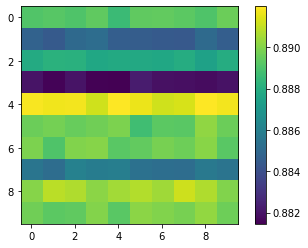

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(simmat_t_w)
plt.colorbar()
plt.show()